In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading in the data:

In [2]:
dataset = pd.read_csv("/home/michael/Code/IrisNeuralNetwork/iris.data.csv")

dataset.columns = ["sepal length (cm)", 
                   "sepal width (cm)", 
                   "petal length (cm)", 
                   "petal width (cm)", 
                   "species"]
mappings = {
   "Iris-setosa": 0,
   "Iris-versicolor": 1,
   "Iris-virginica": 2
}
dataset["species"] = dataset["species"].apply(lambda x: mappings[x])

dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,4.9,3.0,1.4,0.2,0
1,4.7,3.2,1.3,0.2,0
2,4.6,3.1,1.5,0.2,0
3,5.0,3.6,1.4,0.2,0
4,5.4,3.9,1.7,0.4,0


# Plotting the Data:

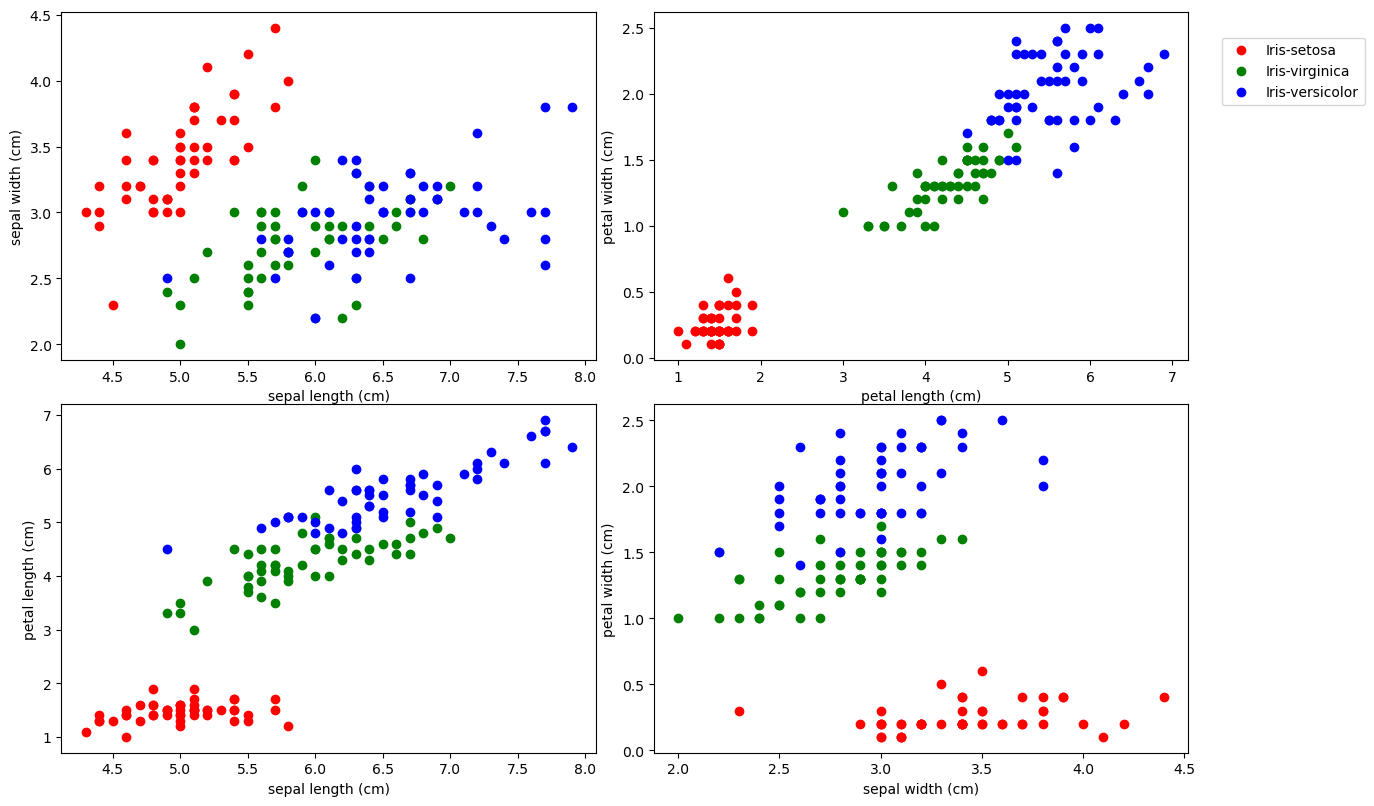

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ["r", "g", "b"]
labels = ["Iris-setosa","Iris-virginica","Iris-versicolor"]

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = dataset.columns[plots[i][0]]
        y = dataset.columns[plots[i][1]]
        ax.scatter(dataset[dataset["species"]==j][x], dataset[dataset["species"]==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

# Creating Training + Test Variables

In [4]:
X = dataset.drop("species",axis=1).values
y = dataset["species"].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

In [6]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Creating a Model

In [14]:
class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=25, hidden_layer2=30, output_features=3):
        super().__init__()
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)                  
        self.out = nn.Linear(hidden_layer2, output_features)      
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
    
model = Model()

# Setting Hyper-Parameters

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training

In [9]:
epochs = 100
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  0  loss: 1.13785195
epoch:  1  loss: 1.07121646
epoch:  2  loss: 1.05370450
epoch:  3  loss: 0.98590332
epoch:  4  loss: 0.94817621
epoch:  5  loss: 0.93314111
epoch:  6  loss: 0.89626324
epoch:  7  loss: 0.84085119
epoch:  8  loss: 0.78601319
epoch:  9  loss: 0.73996192
epoch: 10  loss: 0.69594252
epoch: 11  loss: 0.64801580
epoch: 12  loss: 0.59796137
epoch: 13  loss: 0.55258167
epoch: 14  loss: 0.51574486
epoch: 15  loss: 0.48260763
epoch: 16  loss: 0.45076403
epoch: 17  loss: 0.42236426
epoch: 18  loss: 0.39745730
epoch: 19  loss: 0.37254176
epoch: 20  loss: 0.34905058
epoch: 21  loss: 0.33076620
epoch: 22  loss: 0.31159541
epoch: 23  loss: 0.29076612
epoch: 24  loss: 0.27232105
epoch: 25  loss: 0.25274915
epoch: 26  loss: 0.23429170
epoch: 27  loss: 0.21764010
epoch: 28  loss: 0.19979464
epoch: 29  loss: 0.18477148
epoch: 30  loss: 0.16885629
epoch: 31  loss: 0.15568152
epoch: 32  loss: 0.14216658
epoch: 33  loss: 0.13110189
epoch: 34  loss: 0.11994021
epoch: 35  loss: 0.1

# Training Visualization

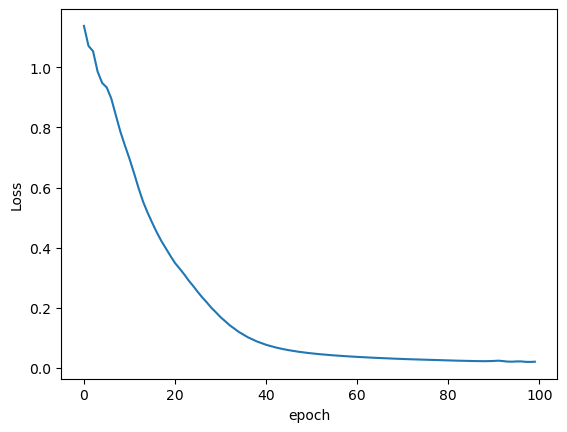

In [10]:
losses = [ loss.detach().numpy() for loss in losses]
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

# Validate + Testing Model

In [11]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())
        
df = pd.DataFrame({'Y': y_test, 'YHat': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]
df

,Y,YHat,Correct
0,0,0,1
1,1,1,1
2,0,0,1
3,2,2,1
4,2,2,1
5,0,0,1
6,2,2,1
7,2,2,1
8,0,0,1
9,2,2,1


# Applying model to Unknown Data

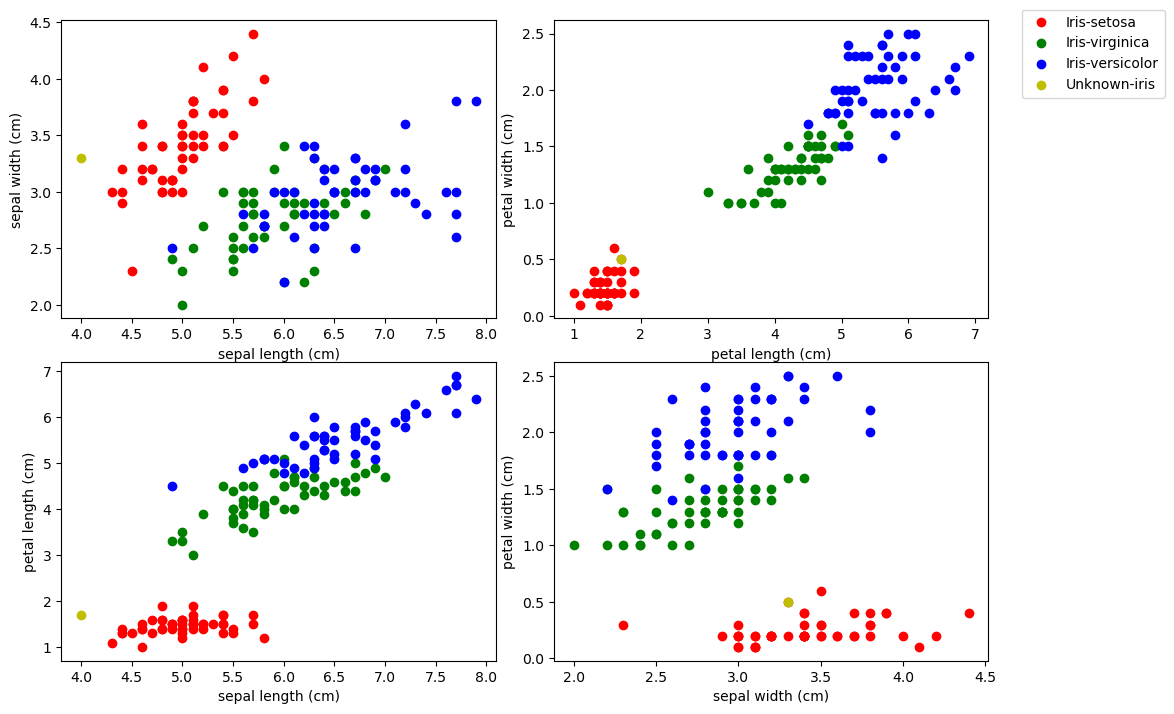

In [12]:
unknown_iris = torch.tensor([4.0,3.3,1.7,0.5])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['r', 'g', 'b']
labels = ['Iris-setosa','Iris-virginica','Iris-versicolor','Unknown-iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = dataset.columns[plots[i][0]]
        y = dataset.columns[plots[i][1]]
        ax.scatter(dataset[dataset["species"]==j][x], dataset[dataset["species"]==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)
        
    # Add a plot for our mystery iris:
    ax.scatter(unknown_iris[plots[i][0]],unknown_iris[plots[i][1]], color='y')
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [13]:
with torch.no_grad():
    print(model(unknown_iris))
    print()
    print(labels[model(unknown_iris).argmax()])

tensor([ 19.1111,  12.9218, -22.9302])

Iris-setosa
